In [79]:
from utils.imports import *
from utils.binary import get_blackhole_binary
from utils.star import make_mesa_star
from utils.plotting import *
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:

converter_grav = nbody_system.nbody_to_si(1 | u.AU, 1 | u.MSun)
converter_hydro = nbody_system.nbody_to_si(1 | u.RSun, 1 | u.MSun)


In [77]:
binary = get_blackhole_binary(60,40)
star = make_mesa_star(N_sph=10000)

offset = [0, -800, 0] | u.RSun                             # <-- increase for smoother/lower-cost interaction
vrel   = [0, 200, 0] | u.km/u.s  
star.position += offset
star.velocity += vrel
gas, core = star[star.name == "gas"],  star[star.name == "core"]

In [76]:
len(gas)

10000

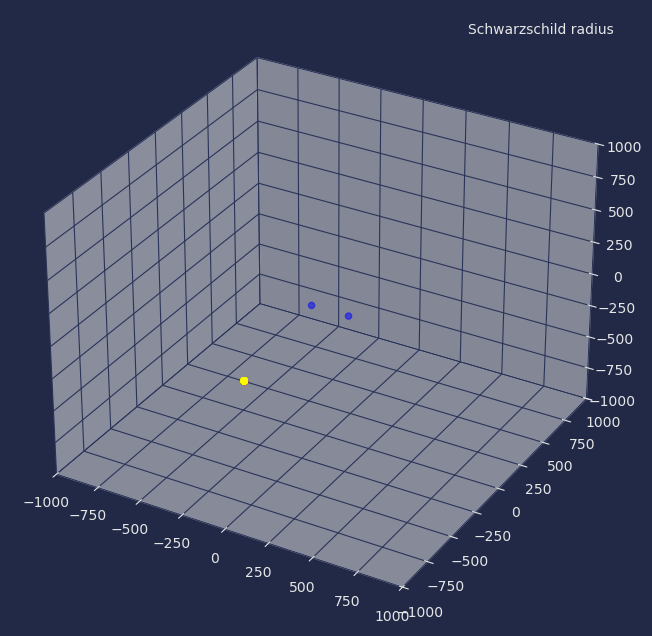

In [6]:
fig = plt.figure(figsize=(8,8))                                # <-- reduce DPI later for speed
ax = fig.add_subplot(111, projection="3d")
ax.axes.set(xlim=(-1000,1000), ylim=(-1000,1000), zlim=(-1000,1000))
ax.scatter(binary.x.value_in(u.RSun), binary.y.value_in(u.RSun), binary.z.value_in(u.RSun), s=binary.radius.value_in(u.RSun), label = "Schwarzschild radius", alpha = 0.5, c="green")
ax.scatter(binary.x.value_in(u.RSun), binary.y.value_in(u.RSun), binary.z.value_in(u.RSun),  alpha=0.5, c="blue" )
ax.scatter(gas.x.value_in(u.RSun), gas.y.value_in(u.RSun), gas.z.value_in(u.RSun), c="yellow", alpha=0.2)
ax.scatter(core.x.value_in(u.RSun), core.y.value_in(u.RSun), core.z.value_in(u.RSun), c="red")
# ax.scatter(binary.center_of_mass().x.value_in(u.AU), binary.center_of_mass().y, marker="x", label="center of mass")
plt.legend()

In [ ]:
gravity = Ph4(converter_grav, mode="CPU")
gravity.parameters.epsilon_squared = (0.01 | u.AU)**2     # <-- increase to 0.05–0.1 AU for faster/softer forces
gravity.parameters.timestep_parameter = 0.03              # <-- increase to 0.1 for faster runs

gravity.particles.add_particles(binary)
# gravity.particles.add_particle(core)
model_time = 0 |u.s
t_end = 2 |u.s
# while model_time < t_end:
#     model_time += 1|u.s
#     gravity.evolve_model(model_time)
#     write_set_to_file(binary.savepoint(model_time), "test.hdf5", 'amuse',append_to_file=True)
# gravity.stop()

In [31]:
grav = read_set_from_file("test.hdf5")

In [ ]:

sink_radius = 1.0 | u.AU                                  # <-- decrease to 0.2 AU for faster, smoother runs
sinks = SinkParticles(gravity, sink_radius)
sinks.sink_particles.add_particles(binary)

bh_accreted_mass = 0 | u.MSun
initial_envelope_mass = gas.total_mass()

AttributeError: key

In [61]:
hydro = Fi(converter_hydro)
hydro.gas_particles.add_particles(gas)
hydro.parameters.use_hydro_flag = True
hydro.parameters.self_gravity_flag = True                     # <-- set False for BIG speed boost
hydro.parameters.gamma = 5.0/3.0
hydro.parameters.timestep = 5e3 | u.s                     # <-- increase to 2e4 for faster runs
hydro.parameters.artificial_viscosity_alpha = 0.5             # <-- increase to 1.0 to stabilize when fast-mode



In [62]:

bridge = Bridge(use_threading=False)
bridge.add_system(gravity, (hydro,))
bridge.add_system(hydro, (gravity,))
bridge.timestep = 0.2 | u.day                              # <-- increase to 1 day for speed (less accuracy)

In [64]:
while model_time < 1|u.day:
    model_time += 0.1 |u.day
    bridge.evolve_model(model_time)
    write_set_to_file(bridge.particles, "testb.hdf5", 'amuse',append_to_file=True)
gravity.stop()
hydro.stop()

In [65]:
p = read_set_from_file("testb.hdf5")

In [71]:
[i for i in list(p.history)]


In [69]:
print(list(p.history))

[<amuse.datamodel.particles.Particles object at 0x7ccbcacb89b0>, <amuse.datamodel.particles.Particles object at 0x7ccbcacb9760>, <amuse.datamodel.particles.Particles object at 0x7ccbcacba060>, <amuse.datamodel.particles.Particles object at 0x7ccbcacbb0b0>, <amuse.datamodel.particles.Particles object at 0x7ccbcacbb260>, <amuse.datamodel.particles.Particles object at 0x7ccbc25cc4d0>, <amuse.datamodel.particles.Particles object at 0x7ccbccedb290>, <amuse.datamodel.particles.Particles object at 0x7ccbc2602f00>, <amuse.datamodel.particles.Particles object at 0x7ccbc2603ce0>]


In [78]:
gas.total_mass()

quantity<1.58323099176e+30 kg>